<a href="https://colab.research.google.com/github/Zardian18/food-vision-mini/blob/master/06_Food_Vision_mini.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Scaling up using transfer learning

In [1]:
!wget https://raw.githubusercontent.com/Zardian18/helper-functions-colab/master/helper.py

--2023-11-03 06:29:50--  https://raw.githubusercontent.com/Zardian18/helper-functions-colab/master/helper.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11274 (11K) [text/plain]
Saving to: ‘helper.py’

helper.py           100%[===================>]  11.01K  --.-KB/s    in 0.001s  

2023-11-03 06:29:50 (14.7 MB/s) - ‘helper.py’ saved [11274/11274]



In [2]:
from helper import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir

## Getting data ready

In [3]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip

unzip_data("101_food_classes_10_percent.zip")

--2023-11-03 06:29:54--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.199.207, 74.125.20.207, 74.125.197.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.199.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G   147MB/s    in 12s     

2023-11-03 06:30:06 (128 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [4]:
train_dir= "101_food_classes_10_percent/train/"
test_dir="101_food_classes_10_percent/test/"

In [5]:
walk_through_dir("101_food_classes_10_percent")

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/test'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/macarons'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/hot_and_sour_soup'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/fried_rice'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/cannoli'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/baby_back_ribs'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/onion_rings'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/lobster_bisque'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/sashimi'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/creme_brulee'.
There are 0 directories and 250 images i

In [6]:
import tensorflow as tf

IMG_SIZE=(224,224)
BATCH_SIZE=32

train_data_all_10_percent= tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                image_size=IMG_SIZE,
                                                                label_mode="categorical",
                                                                batch_size=BATCH_SIZE)

test_data= tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                image_size=IMG_SIZE,
                                                                label_mode="categorical",
                                                                batch_size=BATCH_SIZE,
                                                                shuffle=False)

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


In [7]:
train_data_all_10_percent

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 101), dtype=tf.float32, name=None))>

In [8]:
test_data

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 101), dtype=tf.float32, name=None))>

## Training a model with all 101 classes with only 10% of the data

Steps:

* Create Model checkpoint callback
* Create a data augmentation layer (sequential api model)
* Build a headless (no top layer) Functional EfficientnetB0 backboned-model
* Compile
* Feature extraction

In [9]:
checkpoint_path="checkpoint/models"
checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                       save_weights_only=True,
                                                       monitor="val_accuracy",
                                                       save_best_only=True)

### Data Augmentation layer

In [10]:
from keras.api._v2.keras import preprocessing
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

data_augmentation= Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomZoom(0.2)
], name="data_augmentation")

### Headless model

In [11]:
base_model= tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)
base_model.trainable=False

inputs= layers.Input(shape=IMG_SIZE+(3,), name="input_layer")
x= data_augmentation(inputs)
x= base_model(x, training=False)
x= layers.GlobalAveragePooling2D(name="global_average_pooling")(x)
outputs= layers.Dense(101, activation="softmax", name="output_layer")(x)

model0=tf.keras.Model(inputs, outputs)


24274472/24274472 [==============================] - 0s 0us/step


In [12]:
model0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequent  (None, None, None, 3)     0         
 ial)                                                            
                                                                 
 efficientnetv2-b0 (Functio  (None, None, None, 1280   5919312   
 nal)                        )                                   
                                                                 
 global_average_pooling (Gl  (None, 1280)              0         
 obalAveragePooling2D)                                           
                                                                 
 output_layer (Dense)        (None, 101)               129381    
                                                             

In [13]:
model0.compile(loss=tf.keras.losses.categorical_crossentropy,
               optimizer=tf.keras.optimizers.Adam(),
               metrics=["accuracy"])

In [14]:
history0= model0.fit(train_data_all_10_percent,
                     epochs=5,
                     steps_per_epoch=len(train_data_all_10_percent),
                     validation_data=test_data,
                     validation_steps=int(0.15*len(test_data)),
                     callbacks=[create_tensorboard_callback("transfer_learning", "model0"), checkpoint_callback])


Saving TensorBoard log files to: transfer_learning/model0/20231103-063041
Epoch 1/5
237/237 [==============================] - 159s 597ms/step - loss: 3.5253 - accuracy: 0.2417 - val_loss: 2.7391 - val_accuracy: 0.3867
Epoch 2/5
237/237 [==============================] - 97s 410ms/step - loss: 2.4300 - accuracy: 0.4477 - val_loss: 2.2157 - val_accuracy: 0.4701
Epoch 3/5
237/237 [==============================] - 80s 335ms/step - loss: 2.0545 - accuracy: 0.5160 - val_loss: 2.0379 - val_accuracy: 0.4958
Epoch 4/5
237/237 [==============================] - 73s 306ms/step - loss: 1.8470 - accuracy: 0.5517 - val_loss: 1.9394 - val_accuracy: 0.5106
Epoch 5/5
237/237 [==============================] - 66s 279ms/step - loss: 1.6932 - accuracy: 0.5844 - val_loss: 1.8635 - val_accuracy: 0.5241


In [15]:
!nvidia-smi

Fri Nov  3 06:39:37 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   75C    P0    45W /  70W |   2855MiB / 15360MiB |      1%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [16]:
results0=model0.evaluate(test_data)

790/790 [==============================] - 57s 73ms/step - loss: 1.6188 - accuracy: 0.5743


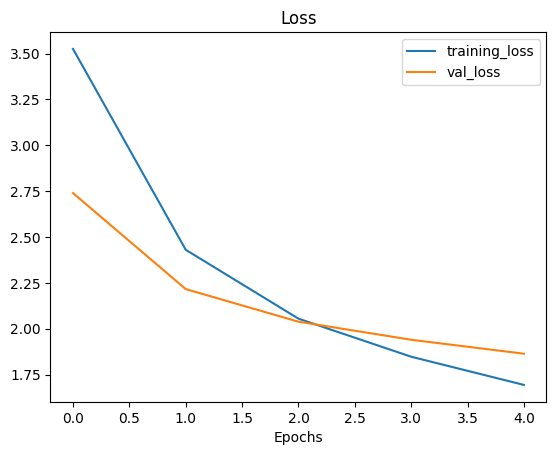

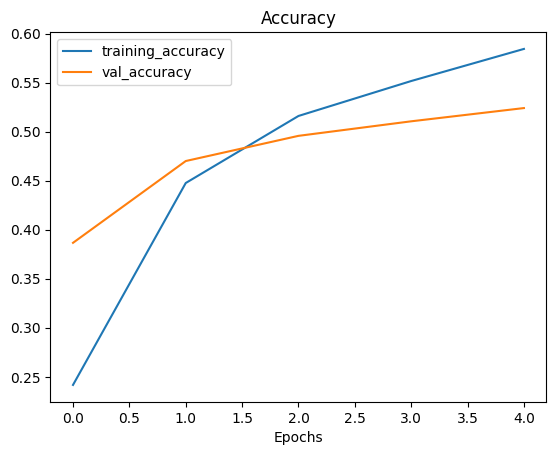

In [17]:
plot_loss_curves(history0)

### Fine tuning

In [18]:
model0.trainable=True

for layer in model0.layers[2].layers[:-5]:
  layer.trainable=False

In [19]:
for i, layer in enumerate(model0.layers[2].layers):
  print(i, layer.name, layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 stem_conv False
4 stem_bn False
5 stem_activation False
6 block1a_project_conv False
7 block1a_project_bn False
8 block1a_project_activation False
9 block2a_expand_conv False
10 block2a_expand_bn False
11 block2a_expand_activation False
12 block2a_project_conv False
13 block2a_project_bn False
14 block2b_expand_conv False
15 block2b_expand_bn False
16 block2b_expand_activation False
17 block2b_project_conv False
18 block2b_project_bn False
19 block2b_drop False
20 block2b_add False
21 block3a_expand_conv False
22 block3a_expand_bn False
23 block3a_expand_activation False
24 block3a_project_conv False
25 block3a_project_bn False
26 block3b_expand_conv False
27 block3b_expand_bn False
28 block3b_expand_activation False
29 block3b_project_conv False
30 block3b_project_bn False
31 block3b_drop False
32 block3b_add False
33 block4a_expand_conv False
34 block4a_expand_bn False
35 block4a_expand_activation False
36 block4a_dwconv2 Fals

In [20]:
model0.compile(loss="categorical_crossentropy",
               optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
               metrics=["accuracy"])

In [21]:
model0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequent  (None, None, None, 3)     0         
 ial)                                                            
                                                                 
 efficientnetv2-b0 (Functio  (None, None, None, 1280   5919312   
 nal)                        )                                   
                                                                 
 global_average_pooling (Gl  (None, 1280)              0         
 obalAveragePooling2D)                                           
                                                                 
 output_layer (Dense)        (None, 101)               129381    
                                                             

In [22]:
for layer in model0.layers:
  print(layer.name, layer.trainable)

input_layer True
data_augmentation True
efficientnetv2-b0 True
global_average_pooling True
output_layer True


Now if we increase the unfrozen layers, we recompile the model with even lower learning rate like 0.000025, 0.00001....

In [23]:
history1= model0.fit(train_data_all_10_percent,
                     epochs=10,
                     steps_per_epoch=len(train_data_all_10_percent),
                     validation_data=test_data,
                     validation_steps=int(0.15* len(test_data)),
                     initial_epoch= history0.epoch[-1],
                     callbacks=[checkpoint_callback])

Epoch 5/10
237/237 [==============================] - 70s 251ms/step - loss: 1.4760 - accuracy: 0.6341 - val_loss: 1.8197 - val_accuracy: 0.5201
Epoch 6/10
237/237 [==============================] - 60s 250ms/step - loss: 1.3884 - accuracy: 0.6442 - val_loss: 1.8088 - val_accuracy: 0.5230
Epoch 7/10
237/237 [==============================] - 52s 216ms/step - loss: 1.3260 - accuracy: 0.6477 - val_loss: 1.8022 - val_accuracy: 0.5265
Epoch 8/10
237/237 [==============================] - 57s 237ms/step - loss: 1.2852 - accuracy: 0.6598 - val_loss: 1.7665 - val_accuracy: 0.5283
Epoch 9/10
237/237 [==============================] - 51s 214ms/step - loss: 1.2466 - accuracy: 0.6733 - val_loss: 1.7397 - val_accuracy: 0.5405
Epoch 10/10
237/237 [==============================] - 53s 224ms/step - loss: 1.2146 - accuracy: 0.6776 - val_loss: 1.7361 - val_accuracy: 0.5434


In [24]:
results1=model0.evaluate(test_data)

790/790 [==============================] - 67s 85ms/step - loss: 1.4775 - accuracy: 0.6027


In [25]:
results0

[1.6188007593154907, 0.5742970108985901]

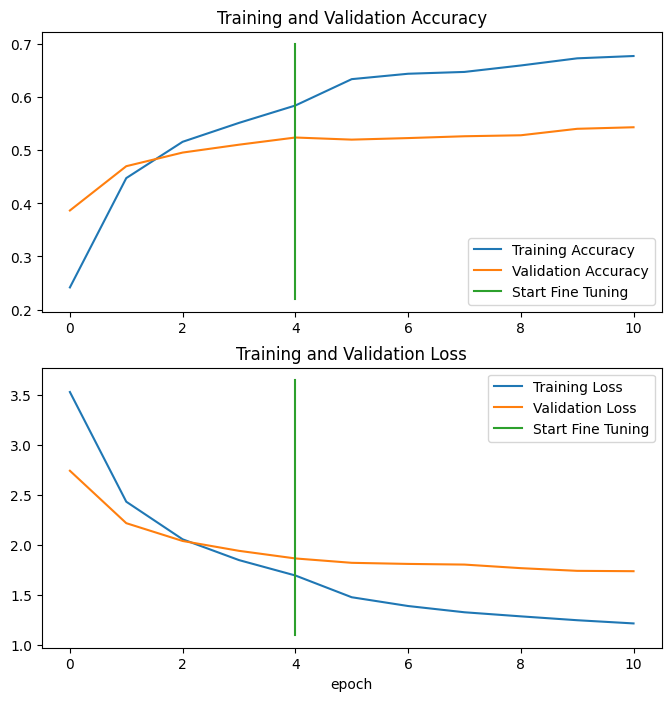

In [26]:
compare_historys(history0, history1, initial_epochs=5)

## Saving and loading the model

In [27]:
model0.save("drive/MyDrive/Machine_Learning/Food_Vision_mini_fine_tuned_2")

In [28]:
loaded_model= tf.keras.models.load_model("drive/MyDrive/Machine_Learning/Food_Vision_mini_fine_tuned_2")

In [29]:
loaded_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequent  (None, None, None, 3)     0         
 ial)                                                            
                                                                 
 efficientnetv2-b0 (Functio  (None, None, None, 1280   5919312   
 nal)                        )                                   
                                                                 
 global_average_pooling (Gl  (None, 1280)              0         
 obalAveragePooling2D)                                           
                                                                 
 output_layer (Dense)        (None, 101)               129381    
                                                             

In [30]:
loaded_model.evaluate(test_data)

790/790 [==============================] - 61s 74ms/step - loss: 1.4775 - accuracy: 0.6027


[1.4775103330612183, 0.6027326583862305]

In [31]:
results1

[1.4775103330612183, 0.6027326583862305]

In [32]:
model0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequent  (None, None, None, 3)     0         
 ial)                                                            
                                                                 
 efficientnetv2-b0 (Functio  (None, None, None, 1280   5919312   
 nal)                        )                                   
                                                                 
 global_average_pooling (Gl  (None, 1280)              0         
 obalAveragePooling2D)                                           
                                                                 
 output_layer (Dense)        (None, 101)               129381    
                                                             

## Making predictions with out trained model

In [33]:
pred_probs= loaded_model.predict(test_data, verbose=1)
pred_probs

790/790 [==============================] - 59s 73ms/step


array([[1.53085333e-03, 1.76134599e-05, 3.35517168e-01, ...,
        2.37159134e-06, 8.46561510e-04, 5.62372661e-05],
       [7.22928584e-01, 1.06830647e-07, 2.46211365e-02, ...,
        8.81309155e-04, 1.79994129e-06, 1.06264924e-04],
       [4.56711590e-01, 3.70028662e-04, 3.19937095e-02, ...,
        1.99000374e-03, 1.18660287e-03, 7.79807509e-04],
       ...,
       [1.55411323e-03, 5.22780605e-03, 2.41656380e-05, ...,
        3.60380975e-04, 1.36114256e-02, 2.89565958e-02],
       [1.55648487e-02, 1.11434341e-03, 5.01379743e-03, ...,
        6.56425487e-03, 2.76387174e-04, 2.37928689e-01],
       [1.98874362e-02, 7.09748175e-03, 5.58422878e-03, ...,
        4.04058304e-03, 2.64536869e-03, 1.48602352e-01]], dtype=float32)

In [34]:
len(pred_probs)

25250

In [35]:
pred_probs[0].argmax()

85

In [36]:
test_data.class_names[85]

'samosa'

In [37]:
sum(pred_probs[0])

0.9999999834965081

In [38]:
pred_classes= pred_probs.argmax(axis=1)

In [39]:
pred_classes

array([ 85,   0,   0, ...,  56, 100,  93])

In [40]:
test_data

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 101), dtype=tf.float32, name=None))>

## Unravelling the batch data

In [41]:
y_labels=[]

for image, labels in test_data.unbatch():
  y_labels.append(labels.numpy().argmax())

In [42]:
y_labels[:10]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [43]:
from sklearn.metrics import accuracy_score

acc= accuracy_score(y_labels, pred_classes)

In [44]:
acc

0.6027326732673267

In [45]:
results1

[1.4775103330612183, 0.6027326583862305]

In [46]:
import numpy as np
np.isclose(results1[1], acc)

True

In [47]:
from helper import make_confusion_matrix

In [48]:
make_confusion_matrix(y_labels, pred_classes, classes=test_data.class_names, figsize=(100,100))

In [49]:
from sklearn.metrics import classification_report

In [50]:
print(classification_report(y_labels, pred_classes))

              precision    recall  f1-score   support

           0       0.35      0.22      0.27       250
           1       0.66      0.65      0.65       250
           2       0.68      0.55      0.61       250
           3       0.70      0.54      0.61       250
           4       0.58      0.36      0.45       250
           5       0.57      0.40      0.47       250
           6       0.72      0.80      0.76       250
           7       0.79      0.70      0.75       250
           8       0.30      0.56      0.39       250
           9       0.38      0.74      0.51       250
          10       0.57      0.44      0.50       250
          11       0.67      0.57      0.62       250
          12       0.71      0.60      0.65       250
          13       0.61      0.51      0.56       250
          14       0.56      0.54      0.55       250
          15       0.40      0.32      0.36       250
          16       0.64      0.49      0.56       250
          17       0.46    

In [51]:
classification_dict= classification_report(y_labels, pred_classes, output_dict=True)
classification_dict

{'0': {'precision': 0.35443037974683544,
  'recall': 0.224,
  'f1-score': 0.27450980392156865,
  'support': 250},
 '1': {'precision': 0.6612244897959184,
  'recall': 0.648,
  'f1-score': 0.6545454545454545,
  'support': 250},
 '2': {'precision': 0.6782178217821783,
  'recall': 0.548,
  'f1-score': 0.6061946902654867,
  'support': 250},
 '3': {'precision': 0.7010309278350515,
  'recall': 0.544,
  'f1-score': 0.6126126126126127,
  'support': 250},
 '4': {'precision': 0.5844155844155844,
  'recall': 0.36,
  'f1-score': 0.44554455445544555,
  'support': 250},
 '5': {'precision': 0.5747126436781609,
  'recall': 0.4,
  'f1-score': 0.4716981132075472,
  'support': 250},
 '6': {'precision': 0.7210144927536232,
  'recall': 0.796,
  'f1-score': 0.7566539923954372,
  'support': 250},
 '7': {'precision': 0.7927927927927928,
  'recall': 0.704,
  'f1-score': 0.7457627118644067,
  'support': 250},
 '8': {'precision': 0.29637526652452023,
  'recall': 0.556,
  'f1-score': 0.3866481223922114,
  'support

In [52]:
class_names= test_data.class_names

## Plotting Classname vs F1 score

In [53]:
class_f1_score={}

for k, v in classification_dict.items():
  if k=="accuracy":
    break
  else:
    class_f1_score[class_names[int(k)]]=v["f1-score"]

In [54]:
class_f1_score

{'apple_pie': 0.27450980392156865,
 'baby_back_ribs': 0.6545454545454545,
 'baklava': 0.6061946902654867,
 'beef_carpaccio': 0.6126126126126127,
 'beef_tartare': 0.44554455445544555,
 'beet_salad': 0.4716981132075472,
 'beignets': 0.7566539923954372,
 'bibimbap': 0.7457627118644067,
 'bread_pudding': 0.3866481223922114,
 'breakfast_burrito': 0.5068119891008175,
 'bruschetta': 0.49887640449438203,
 'caesar_salad': 0.6177105831533477,
 'cannoli': 0.6478260869565217,
 'caprese_salad': 0.5565217391304348,
 'carrot_cake': 0.5510204081632654,
 'ceviche': 0.3592017738359202,
 'cheese_plate': 0.5565610859728507,
 'cheesecake': 0.42918454935622324,
 'chicken_curry': 0.48602150537634403,
 'chicken_quesadilla': 0.5754527162977867,
 'chicken_wings': 0.6951672862453532,
 'chocolate_cake': 0.574757281553398,
 'chocolate_mousse': 0.42857142857142855,
 'churros': 0.7419354838709676,
 'clam_chowder': 0.7510729613733905,
 'club_sandwich': 0.6403326403326403,
 'crab_cakes': 0.40446304044630405,
 'creme_b

In [55]:
# turing f1 scores to dataframe
import pandas as pd
f1_scores= pd.DataFrame({"class_names": list(class_f1_score.keys()),
                         "f1-score": list(class_f1_score.values())}).sort_values("f1-score", ascending=False)

In [56]:
f1_scores[:10]

class_names  f1-score
33              edamame  0.966732
63             macarons  0.885033
75                  pho  0.872211
69              oysters  0.839506
86              sashimi  0.836439
88        seaweed_salad  0.836134
45        frozen_yogurt  0.834382
54    hot_and_sour_soup  0.832981
65              mussels  0.830898
91  spaghetti_carbonara  0.822917

<ipython-input-57-96ad3baeed5a>:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=f1_scores["class_names"], rotation=90);


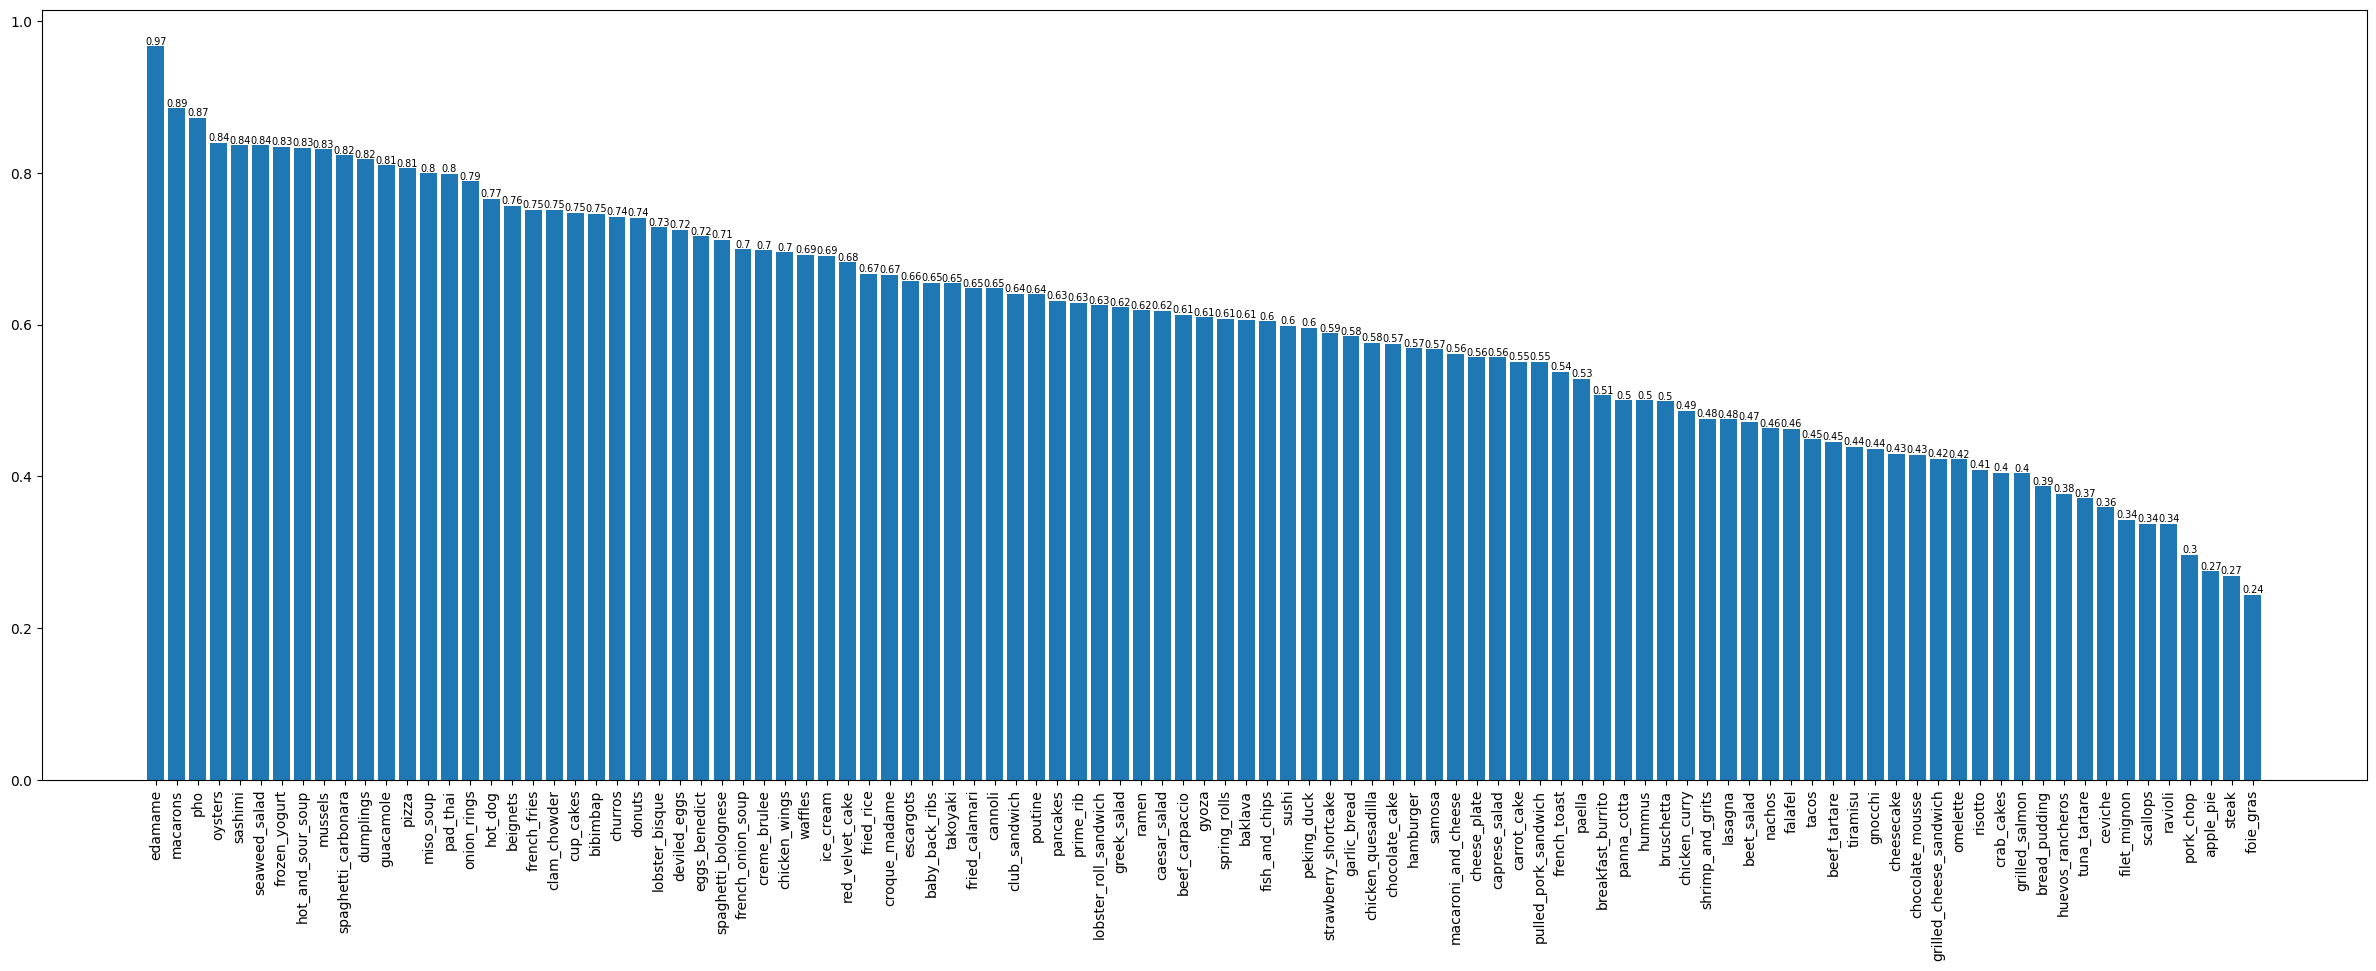

In [57]:
import matplotlib.pyplot as plt

fig, ax= plt.subplots(figsize=(30,10))

ax.bar(f1_scores["class_names"], f1_scores["f1-score"])
ax.set_xticklabels(labels=f1_scores["class_names"], rotation=90);
for i, value in enumerate(f1_scores["f1-score"]):
  ax.text(i, value, str(round(value,2)),ha="center", va="bottom", fontsize=7)

plt.show();

# plt.xticks(labels=f1_scores["class_names"]);

In [58]:
import random
import os
from helper import load_and_prep_image, pred_and_plot
def plot_and_predict(model, target_dir, target_class, img_size=224):
  target_folder= target_dir+ target_class
  random_img= random.sample(os.listdir(target_folder),1)
  img_path= target_folder+"/"+random_img[0]
  # pred_and_plot(model, img_path,class_names)

  img= plt.imread(img_path)
  # loaded_img= tf.image.resize(load_and_prep_image(tf.constant(img, dtype=)), [224,224])
  img2=tf.image.resize(img, [img_size,img_size])
  pred=model.predict(tf.expand_dims(img2,axis=0))
  predicted_class= class_names[pred.argmax()]
  plt.imshow(img)
  plt.axis(False)
  if predicted_class== target_class:
    c="green"
  else:
    c="red"
  plt.title(f"Predicted {predicted_class}   Actual: {target_class}  probablity={pred.max()}", fontdict={'color':c})

1/1 [==============================] - 0s 29ms/step


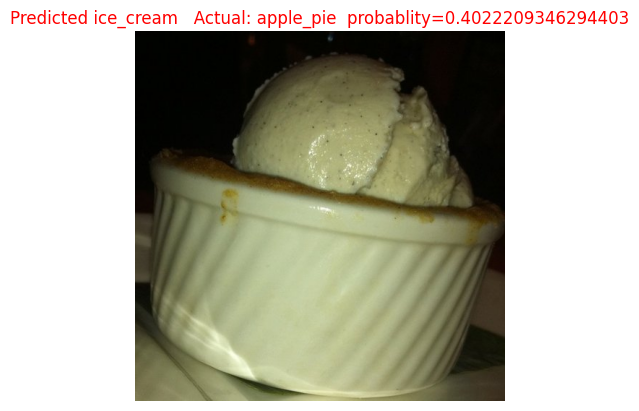

In [ ]:
plot_and_predict(loaded_model, test_dir, "apple_pie")

## Most wrong predictions

1. Get all of the image file paths in the test dataset using `list_files()` method
2. Create pandas df of the image filepaths, ground truth labels, predicted class and labels
3. Use the df to find wrong preds
4. Sort df based on preds
5. Visualize image with highest pred probs but incorrect

In [61]:
#1.
filepaths=[]

for filepath in test_data.list_files("/content/101_food_classes_10_percent/test/*/*.jpg", shuffle=False):
  filepaths.append(filepath.numpy())


In [62]:
filepaths[:10]

[b'/content/101_food_classes_10_percent/test/apple_pie/1011328.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/101251.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1034399.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/103801.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1038694.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1047447.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1068632.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/110043.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1106961.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1113017.jpg']

In [64]:
#2.
import pandas as pd

pred_df= pd.DataFrame({"img_path":filepaths,
                      "y_true": y_labels,
                      "y_pred": pred_classes,
                      "probablity": pred_probs.max(axis=1),
                       "y_true_class_names": [class_names[i] for i in y_labels],
                       "y_pred_class_names": [class_names[i] for i in pred_classes]})

In [65]:
pred_df

img_path  y_true  y_pred  \
0      b'/content/101_food_classes_10_percent/test/ap...       0      85   
1      b'/content/101_food_classes_10_percent/test/ap...       0       0   
2      b'/content/101_food_classes_10_percent/test/ap...       0       0   
3      b'/content/101_food_classes_10_percent/test/ap...       0       0   
4      b'/content/101_food_classes_10_percent/test/ap...       0       8   
...                                                  ...     ...     ...   
25245  b'/content/101_food_classes_10_percent/test/wa...     100     100   
25246  b'/content/101_food_classes_10_percent/test/wa...     100     100   
25247  b'/content/101_food_classes_10_percent/test/wa...     100      56   
25248  b'/content/101_food_classes_10_percent/test/wa...     100     100   
25249  b'/content/101_food_classes_10_percent/test/wa...     100      93   

       probablity y_true_class_names y_pred_class_names  
0        0.360636          apple_pie             samosa  
1        0.722929          apple_pie          apple_pie  
2        0.456712          apple_pie          apple_pie  
3        0.297872          apple_pie          apple_pie  
4        0.628228          apple_pie      bread_pudding  
...           ...                ...                ...  
25245    0.906516            waffles            waffles  
25246    0.965568            waffles            waffles  
25247    0.450804            waffles   huevos_rancheros  
25248    0.237929            waffles            waffles  
25249    0.171176            waffles              steak  

[25250 rows x 6 columns]

In [66]:
#3.
pred_df["isCorrect"]= pred_df["y_true"]== pred_df["y_pred"]

In [67]:
pred_df

img_path  y_true  y_pred  \
0      b'/content/101_food_classes_10_percent/test/ap...       0      85   
1      b'/content/101_food_classes_10_percent/test/ap...       0       0   
2      b'/content/101_food_classes_10_percent/test/ap...       0       0   
3      b'/content/101_food_classes_10_percent/test/ap...       0       0   
4      b'/content/101_food_classes_10_percent/test/ap...       0       8   
...                                                  ...     ...     ...   
25245  b'/content/101_food_classes_10_percent/test/wa...     100     100   
25246  b'/content/101_food_classes_10_percent/test/wa...     100     100   
25247  b'/content/101_food_classes_10_percent/test/wa...     100      56   
25248  b'/content/101_food_classes_10_percent/test/wa...     100     100   
25249  b'/content/101_food_classes_10_percent/test/wa...     100      93   

       probablity y_true_class_names y_pred_class_names  isCorrect  
0        0.360636          apple_pie             samosa      False  
1        0.722929          apple_pie          apple_pie       True  
2        0.456712          apple_pie          apple_pie       True  
3        0.297872          apple_pie          apple_pie       True  
4        0.628228          apple_pie      bread_pudding      False  
...           ...                ...                ...        ...  
25245    0.906516            waffles            waffles       True  
25246    0.965568            waffles            waffles       True  
25247    0.450804            waffles   huevos_rancheros      False  
25248    0.237929            waffles            waffles       True  
25249    0.171176            waffles              steak      False  

[25250 rows x 7 columns]

In [68]:
#4
top_100_wrong= pred_df[pred_df["isCorrect"]==False].sort_values("probablity", ascending=False)[:100]

In [69]:
top_100_wrong

img_path  y_true  y_pred  \
18001  b'/content/101_food_classes_10_percent/test/pa...      72      67   
4836   b'/content/101_food_classes_10_percent/test/ch...      19       9   
14482  b'/content/101_food_classes_10_percent/test/hu...      57      51   
23797  b'/content/101_food_classes_10_percent/test/su...      95      86   
9690   b'/content/101_food_classes_10_percent/test/fi...      38      20   
...                                                  ...     ...     ...   
15144  b'/content/101_food_classes_10_percent/test/lo...      60      64   
12396  b'/content/101_food_classes_10_percent/test/gr...      49      53   
12389  b'/content/101_food_classes_10_percent/test/gr...      49      53   
4851   b'/content/101_food_classes_10_percent/test/ch...      19      51   
19709  b'/content/101_food_classes_10_percent/test/po...      78      40   

       probablity       y_true_class_names y_pred_class_names  isCorrect  
18001    0.998991                 pancakes           omelette      False  
4836     0.996742       chicken_quesadilla  breakfast_burrito      False  
14482    0.996072                   hummus          guacamole      False  
23797    0.995541                    sushi            sashimi      False  
9690     0.994088           fish_and_chips      chicken_wings      False  
...           ...                      ...                ...        ...  
15144    0.952001           lobster_bisque          miso_soup      False  
12396    0.951850  grilled_cheese_sandwich          hamburger      False  
12389    0.951296  grilled_cheese_sandwich          hamburger      False  
4851     0.951066       chicken_quesadilla          guacamole      False  
19709    0.950965                  poutine       french_fries      False  

[100 rows x 7 columns]

In [72]:
top_100_wrong["img_path"][:5]

18001    b'/content/101_food_classes_10_percent/test/pa...
4836     b'/content/101_food_classes_10_percent/test/ch...
14482    b'/content/101_food_classes_10_percent/test/hu...
23797    b'/content/101_food_classes_10_percent/test/su...
9690     b'/content/101_food_classes_10_percent/test/fi...
Name: img_path, dtype: object

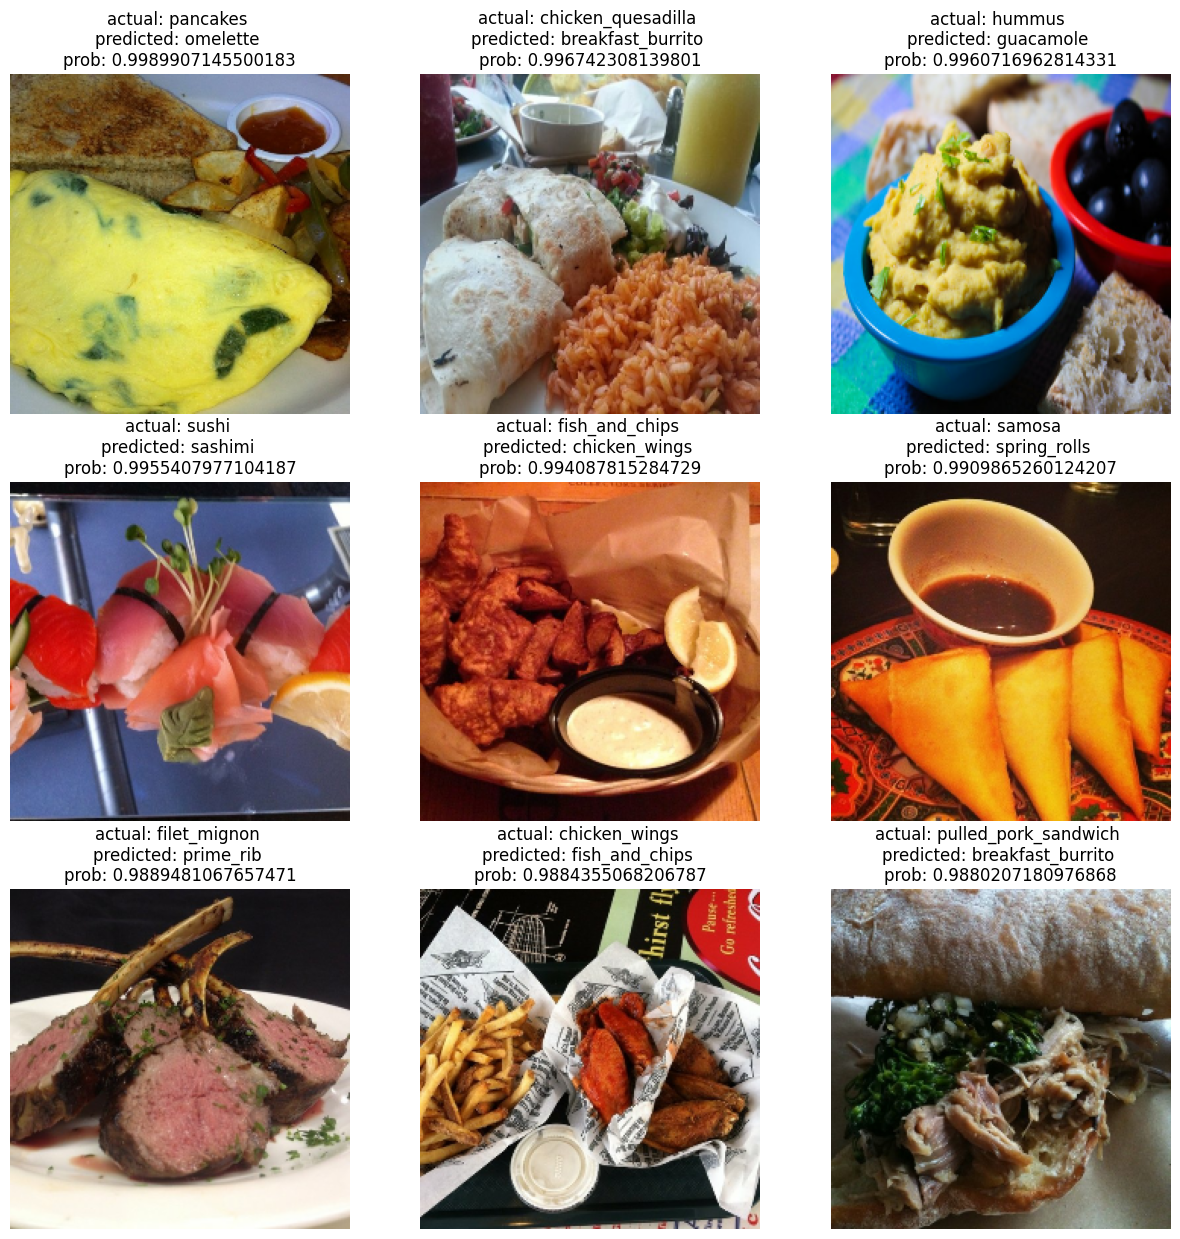

In [106]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

images_to_view=9
start_index=0
plt.figure(figsize=(15,15))
for i, row in enumerate(top_100_wrong[start_index:start_index+images_to_view].itertuples()):
  plt.subplot(3,3,i+1)
  img= load_and_prep_image(row[1], 224, scale=True)
  _, _, _, _, pred_probs, y_true_class_name, y_pred_class_name, _= row
  plt.imshow(img)
  plt.title(f"actual: {y_true_class_name} \npredicted: {y_pred_class_name} \nprob: {pred_probs}")
  plt.axis(False)
  plt.tight_layout